## ERDAP with erddapy example for ITAE Prawler - 2018 St Matt's (MTITAEPR-1A)

__pyversion__==3.7   
__author__==S.Bell

In [3]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2018-11-16 08:06:39.451456


### connecting and basic information

In [4]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

In [5]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='PRAWLER'))

In [6]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 8 tabledap, 0 griddap, and 0 wms endpoints.'

In [7]:
prawlers = df['Dataset ID'].values
print(prawlers)

['erddap_4fd3_fb30_b89f' 'erddap_17bsitae_prawler'
 'erddap_17ckitaem2a_prawler' 'erddap_18bsitaepr2a_prawler'
 'erddap_18mtitaepr1a_prawler' 'erddap_17ckitaem2a_met'
 'erddap_18bsitaepr2a_met' 'erddap_18mtitaepr1a_met']


In [8]:
variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in prawlers]
print(variables)

[['Salinity', 'Chlorophyll', 'time', 'latitude', 'longitude', 'depth'], ['Salinity', 'Chlorophyll', 'time', 'latitude', 'longitude', 'depth'], ['Salinity', 'Chlorophyll', 'time', 'latitude', 'Oxy_Sat', 'longitude', 'depth', 'Temperature', 'SigmaT', 'Oxy_Conc', 'Oxy_Temperature', 'Turbidity'], ['Chlorophyll', 'time', 'latitude', 'longitude', 'depth', 'Salinity'], ['Chlorophyll', 'time', 'latitude', 'longitude', 'depth', 'Salinity'], ['wind_speed', 'latitude', 'northward_wind', 'longitude', 'eastward_wind', 'air_temperature', 'air_pressure', 'wind_from_direction', 'relative_humidity', 'time'], ['wind_speed', 'latitude', 'northward_wind', 'longitude', 'eastward_wind', 'air_temperature', 'air_pressure', 'wind_from_direction', 'relative_humidity', 'time'], ['wind_speed', 'latitude', 'northward_wind', 'longitude', 'eastward_wind', 'air_temperature', 'air_pressure', 'wind_from_direction', 'relative_humidity', 'time']]


### retrieving and plotting data

In [9]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='erddap_18mtitaepr1a_prawler'

d.variables =  [
 'profile_id',
 'Temperature',
 'Salinity',
 'Chlorophyll',
 'Turbidity',
 'latitude',
 'longitude',
 'depth',
 'time',
 'Oxy_Conc',
 'Oxy_Sat'
]

d.constraints = {
    'time>=': '2018-01-01T00:00:00Z',
    'time<=': '2018-10-10T00:00:00Z',
    'latitude>=': 45,
    'latitude<=': 90,
    'longitude>=': 180,
    'longitude<=': 210,
    'profile_id!=': '18mtitaepr1a_met'
}

In [10]:
d.get_download_url()

'http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/erddap_18mtitaepr1a_prawler.csv?profile_id,Temperature,Salinity,Chlorophyll,Turbidity,latitude,longitude,depth,time,Oxy_Conc,Oxy_Sat&time>=1514764800.0&time<=1539129600.0&latitude>=45&latitude<=90&longitude>=180&longitude<=210&profile_id!="18mtitaepr1a_met"'

In [11]:
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.head()

,profile_id,Temperature,Salinity (PSU),Chlorophyll,Turbidity,latitude (degrees_north),longitude (degrees_east),depth (m),Oxy_Conc,Oxy_Sat (percent)
time (UTC),,,,,,,,,,
2018-05-05 02:32:43,18mtitaepr1a_p0003,1.586,32.137,0.753,1.476,60.026001,187.210007,4.4,338.50867,101.66422
2018-05-05 02:32:51,18mtitaepr1a_p0003,1.584,32.138,0.728,1.476,60.026001,187.210007,4.8,338.39890,101.62715
2018-05-05 02:32:59,18mtitaepr1a_p0003,1.584,32.137,0.753,1.687,60.026001,187.210007,4.9,338.21445,101.57095
2018-05-05 02:33:07,18mtitaepr1a_p0003,1.584,32.137,0.728,1.476,60.026001,187.210007,4.3,338.42032,101.63249
2018-05-05 02:33:15,18mtitaepr1a_p0003,1.583,32.136,0.602,1.265,60.026001,187.210007,3.5,338.41486,101.62704


In [12]:
df.tail()

,profile_id,Temperature,Salinity (PSU),Chlorophyll,Turbidity,latitude (degrees_north),longitude (degrees_east),depth (m),Oxy_Conc,Oxy_Sat (percent)
time (UTC),,,,,,,,,,
2018-08-18 13:34:28,18mtitaepr1a_p1807,6.292,32.149,0.753,1.054,60.026001,187.210007,38.4,272.69653,91.80347
2018-08-18 13:34:36,18mtitaepr1a_p1807,6.226,32.163,0.803,1.476,60.026001,187.210007,39.5,272.39093,91.57170
2018-08-18 13:34:44,18mtitaepr1a_p1807,6.204,32.161,0.778,1.687,60.026001,187.210007,40.7,271.83176,91.33622
2018-08-18 13:34:52,18mtitaepr1a_p1807,6.200,32.157,1.029,2.531,60.026001,187.210007,41.8,271.20570,91.11490
2018-08-18 13:35:00,18mtitaepr1a_p1807,6.192,32.157,1.004,2.320,60.026001,187.210007,42.6,270.79663,90.96095


#### Temperature

In [13]:
#qc
df['Temperature'][df['Temperature']>20]=np.nan

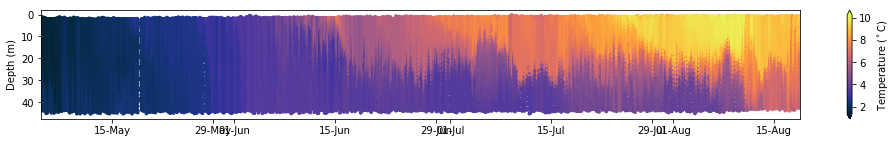

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth (m)'], s=15, c=df['Temperature'], marker='o', edgecolor='none', cmap=cmocean.cm.thermal)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

In [15]:
print("""
max temp: {0:0.4}
min temp: {1:0.4}""".format(df['Temperature'].max(), df['Temperature'].min()))


max temp: 10.23
min temp: 1.342


#### Salinity

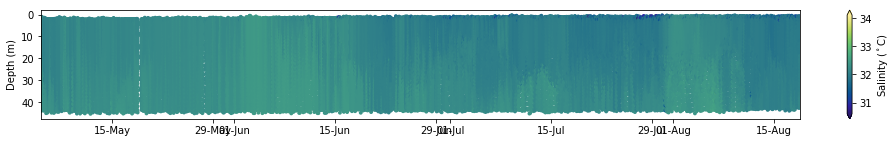

In [16]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth (m)'], s=15, c=df['Salinity (PSU)'], marker='o', edgecolor='none', cmap=cmocean.cm.haline)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity ($^\circ$C)')
ax.set_ylabel('Depth (m)');

In [17]:
print("""
max sal: {0:0.4}
min sal: {1:0.4}""".format(df['Salinity (PSU)'].max(), df['Salinity (PSU)'].min()))


max sal: 34.1
min sal: 30.6


#### Chlorophyl

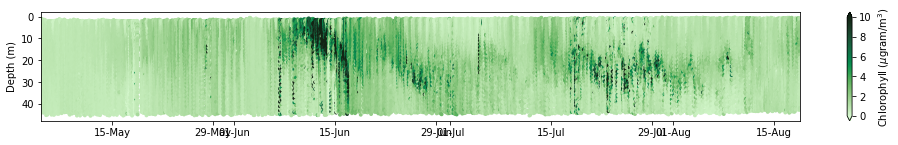

In [18]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth (m)'], s=15, c=df['Chlorophyll'], marker='o', edgecolor='none', vmin=0, vmax=10, cmap=cmocean.cm.algae)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll ($\mu$gram/m$^3$)')
ax.set_ylabel('Depth (m)');

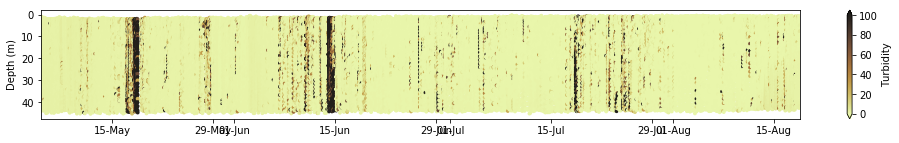

In [19]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth (m)'], s=15, c=df['Turbidity'], marker='o', edgecolor='none', vmin=0, vmax=100, cmap=cmocean.cm.turbid)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Turbidity')
ax.set_ylabel('Depth (m)');

In [20]:
import seawater as sw
sigmat = sw.dens(s=df['Salinity (PSU)'],t=df['Temperature'],p=df['depth (m)']) - 1000.

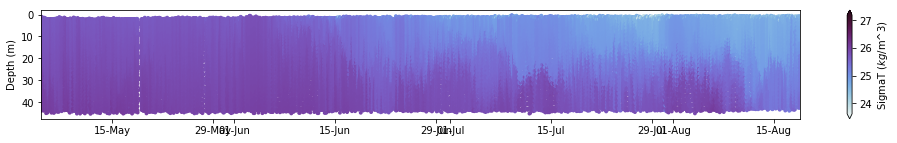

In [21]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth (m)'], s=15, c=sigmat, marker='o', edgecolor='none', cmap=cmocean.cm.dense)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('SigmaT ($kg/$m^3)')
ax.set_ylabel('Depth (m)');

### Oxygen by Percent Saturation and Concentration

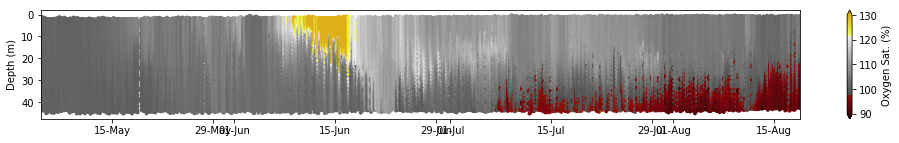

In [22]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth (m)'], s=15, c=df['Oxy_Sat (percent)'], marker='o', vmin=90, vmax=130, edgecolor='none', cmap=cmocean.cm.oxy)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Sat. (%)')
ax.set_ylabel('Depth (m)');

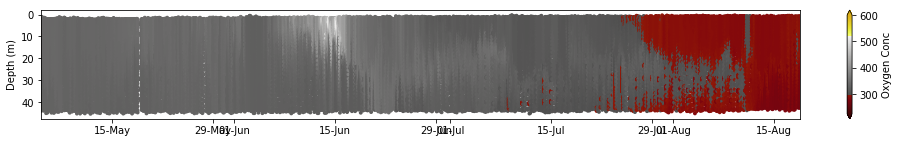

In [23]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth (m)'], s=15, c=df['Oxy_Conc'], marker='o', vmin=225, vmax=600, edgecolor='none', cmap=cmocean.cm.oxy)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Conc')
ax.set_ylabel('Depth (m)');

### Calibration/Characterization Profiles

**Whats the explanation for the clear pattern of cal profiles having lower values than the full profiles as one goes to depth, especially below the pycno/thermocline**
Initial evaluation is that an oxygen sensor lag may be indicating high values of oxygen concentration deeper in the column than is actually the case based on the calibration profiles (full profiles are higher at equivalent depths...)

Lets investigate this by plotting up a few profiles with the corresponding calibration cast.  We need to do it two ways:
- as a function of depth without time to see how they overlay (features on a sub daily timescale may make this hard)
- as a timeseries for each park and hold to see how long the equilibration takes

Lets choose ~~June 25th~~ ** the last day **

__UPDATE__ Recovered at 2018-08-18 20:00:00 UTC so this will be considered the end date

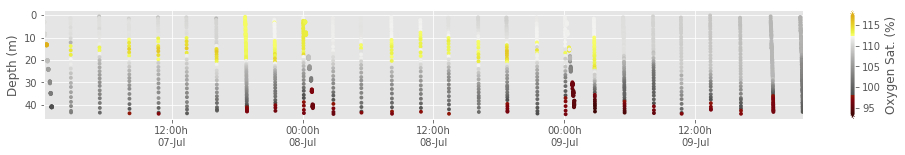

In [40]:
#dfsub = df[datetime.datetime.strftime(datetime.date.today() - datetime.timedelta(hours=24),'%Y-%m-%d'):datetime.datetime.strftime(datetime.date.today(),'%Y-%m-%d')]
dfsub = df['2018-07-7':'2018-07-9']

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(dfsub.index, dfsub['depth (m)'], s=15, c=dfsub['Oxy_Sat (percent)'], marker='o', edgecolor='none', cmap=cmocean.cm.oxy)

ax.invert_yaxis()
ax.set_xlim(dfsub.index[0], dfsub.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Sat. (%)')
ax.set_ylabel('Depth (m)');

In [41]:
#groupby profile id
dfsg = dfsub.groupby('profile_id')

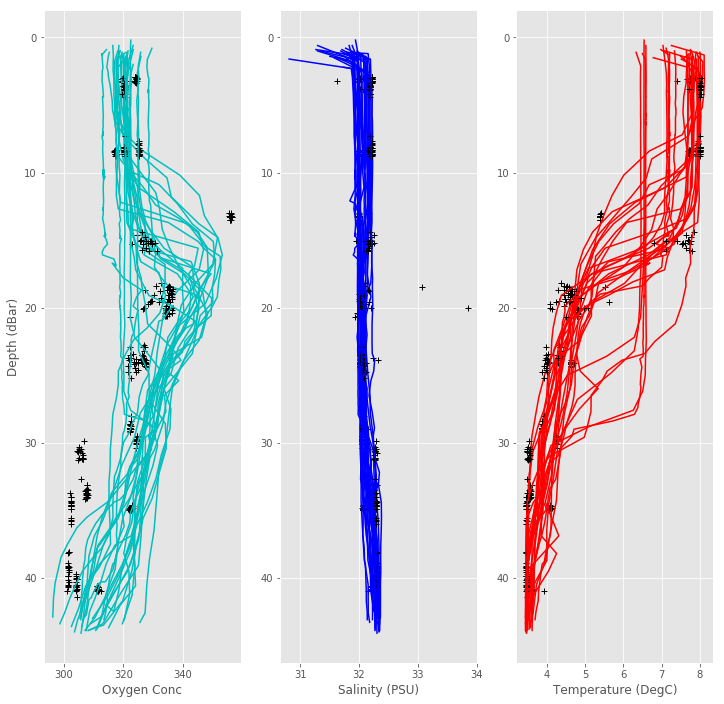

In [42]:
fig, ax = plt.subplots(1,3,figsize=(12, 12))

for i,cast in enumerate(dfsg.groups):
    if dfsg.get_group(cast)['depth (m)'].std() > 1:
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Conc'],dfsg.get_group(cast)['depth (m)'],'c-')
        cs = ax[1].plot(dfsg.get_group(cast)['Salinity (PSU)'],dfsg.get_group(cast)['depth (m)'],'b-')
        cs = ax[2].plot(dfsg.get_group(cast)['Temperature'],dfsg.get_group(cast)['depth (m)'],'r-')
    else:
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Conc'],dfsg.get_group(cast)['depth (m)'],'k+')
        cs = ax[1].plot(dfsg.get_group(cast)['Salinity (PSU)'],dfsg.get_group(cast)['depth (m)'],'k+')
        cs = ax[2].plot(dfsg.get_group(cast)['Temperature'],dfsg.get_group(cast)['depth (m)'],'k+')

ax[0].set_xlabel('Oxygen Conc')        
ax[0].set_ylabel('Depth (dBar)')        
ax[0].invert_yaxis()
ax[1].set_xlabel('Salinity (PSU)')        
ax[1].invert_yaxis()
ax[2].set_xlabel('Temperature (DegC)')        
ax[2].invert_yaxis()

**Top Bin is seems to underestimate... may be contaminated by sfc?** remove it for plotting below.

Also, plot the median value at each calibration park depth instead of every value

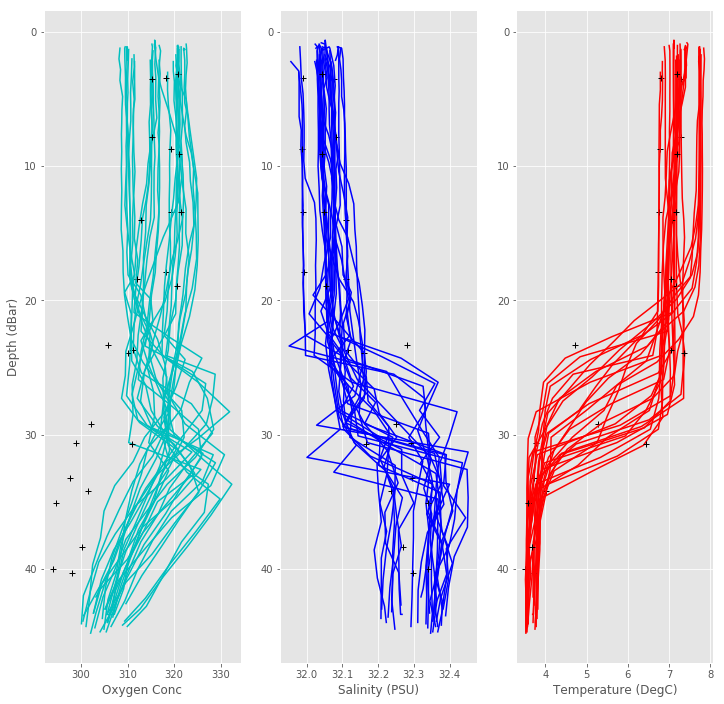

In [39]:
fig, ax = plt.subplots(1,3,figsize=(12, 12))

for i,cast in enumerate(dfsg.groups):
    if dfsg.get_group(cast)['depth (m)'].std() > 1:
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Conc'][1:],dfsg.get_group(cast)['depth (m)'][1:],'c-')
        cs = ax[1].plot(dfsg.get_group(cast)['Salinity (PSU)'][1:],dfsg.get_group(cast)['depth (m)'][1:],'b-')
        cs = ax[2].plot(dfsg.get_group(cast)['Temperature'][1:],dfsg.get_group(cast)['depth (m)'][1:],'r-')
    else:
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Conc'].last('s'),dfsg.get_group(cast)['depth (m)'].last('s'),'k+')
        cs = ax[1].plot(dfsg.get_group(cast)['Salinity (PSU)'].last('s'),dfsg.get_group(cast)['depth (m)'].last('s'),'k+')
        cs = ax[2].plot(dfsg.get_group(cast)['Temperature'].last('s'),dfsg.get_group(cast)['depth (m)'].last('s'),'k+')

ax[0].set_xlabel('Oxygen Conc')        
ax[0].set_ylabel('Depth (dBar)')        
ax[0].invert_yaxis()
ax[1].set_xlabel('Salinity (PSU)')        
ax[1].invert_yaxis()
ax[2].set_xlabel('Temperature (DegC)')        
ax[2].invert_yaxis()

In [43]:
for i,cast in enumerate(dfsg.groups):
    dfsg.get_group(cast).to_csv(str(cast)+'.csv')

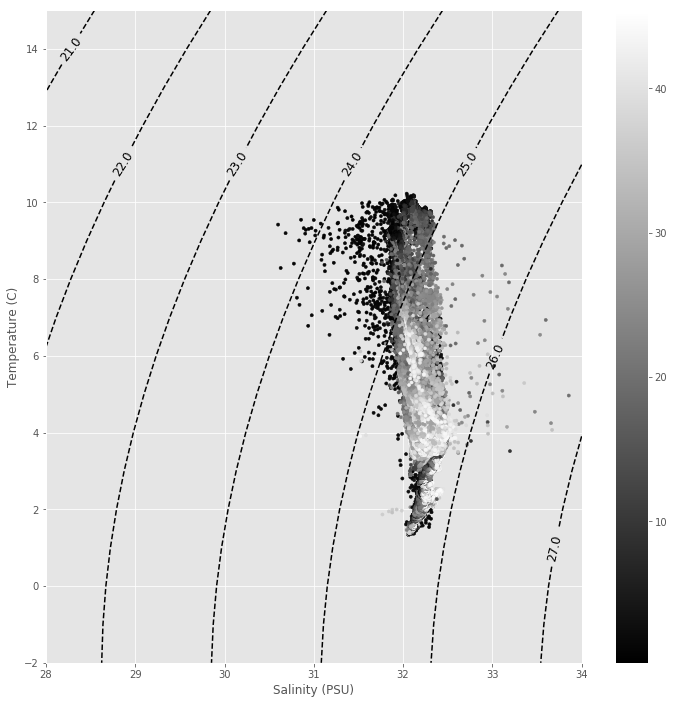

In [35]:
def plot_salvtemp(salt, temp, press, srange=[28,34], trange=[-2,15], ptitle=""): 
    plt.style.use('ggplot')
    
    # Figure out boudaries (mins and maxs)
    smin = srange[0]
    smax = srange[1]
    tmin = trange[0]
    tmax = trange[1]

    # Calculate how many gridcells we need in the x and y dimensions
    xdim = int(round((smax-smin)/0.1+1,0))
    ydim = int(round((tmax-tmin)+1,0))
    
    #print 'ydim: ' + str(ydim) + ' xdim: ' + str(xdim) + ' \n'
    if (xdim > 10000) or (ydim > 10000): 
        print('To many dimensions for grid in {cruise} {cast} file. Likely  missing data \n'.format(cruise=cruise,cast=cast))
        return
 
    # Create empty grid of zeros
    dens = np.zeros((ydim,xdim))
 
    # Create temp and salt vectors of appropiate dimensions
    ti = np.linspace(0,ydim-1,ydim)+tmin
    si = np.linspace(0,xdim-1,xdim)*0.1+smin
 
    # Loop to fill in grid with densities
    for j in range(0,int(ydim)):
        for i in range(0, int(xdim)):
            dens[j,i]=sw.dens0(si[i],ti[j])
 
    # Substract 1000 to convert to sigma-t
    dens = dens - 1000
 
    # Plot data ***********************************************
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(111)
    CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k')
    plt.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
 
    ts = ax1.scatter(salt,temp, c=press, cmap='gray', s=10)
    plt.colorbar(ts )
    plt.ylim(tmin,tmax)
    plt.xlim(smin,smax)
 
    ax1.set_xlabel('Salinity (PSU)')
    ax1.set_ylabel('Temperature (C)')

    
    t = fig.suptitle(ptitle, fontsize=12, fontweight='bold')
    t.set_y(1.08)
    return fig  

fig = plot_salvtemp(df['Salinity (PSU)'],df['Temperature'],df['depth (m)'])

### Mooring Broke Free - July 10th

### Bin data to calculate integrate heat proxy (depth averaged temperature)

Setup 1m bins

In [29]:
#depth averaged temp - interpolate to 1m bins before averaging
def depth_ave(param):
    dfint= df.groupby('profile_id')

    fig, ax = plt.subplots(figsize=(17, 2))

    for i,cast in enumerate(dfint.groups):
        if dfint.get_group(cast)['depth (m)'].std() > 1:
            IntTemp = np.interp(np.arange(0,70,1),dfint.get_group(cast)['depth (m)'], dfint.get_group(cast)[param], right=np.nan)
            cs = ax.scatter(dfint.get_group(cast).index[0], np.nanmean(IntTemp), s=15, c='g', marker='o', edgecolor='none')
            IntTemp = np.interp(np.arange(0,70,1),dfint.get_group(cast)['depth (m)'], dfint.get_group(cast)[param])
            cs = ax.scatter(dfint.get_group(cast).index[0], np.nanmean(IntTemp), s=15, c='r', marker='o', edgecolor='none')

        xfmt = mdates.DateFormatter('%d-%b')
        ax.xaxis.set_major_formatter(xfmt)

        ax.set_ylabel(param)
        ax.set_xlabel('Time (UTC)')  


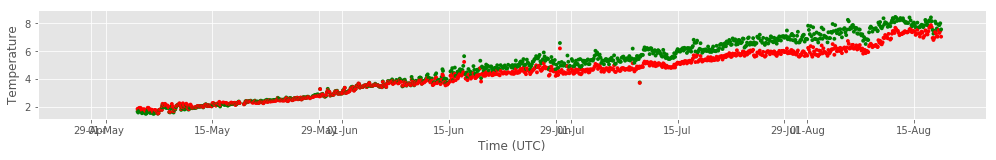

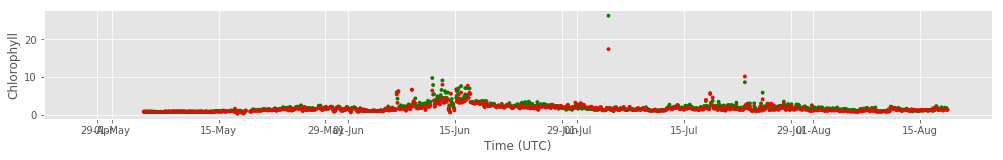

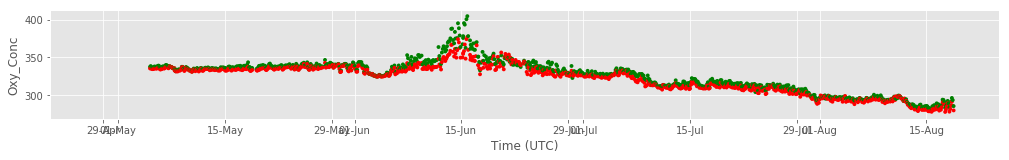

In [30]:
#depth averaged temp - interpolate to 1m bins before averaging
depth_ave('Temperature')
#depth averaged chlor - interpolate to 1m bins before averaging
depth_ave('Chlorophyll')
#depth averaged oxy - interpolate to 1m bins before averaging
depth_ave('Oxy_Conc')

- Above plots, red plots result from extrapolating the last point down to 70m, and up to the sfc then taking the mean.  Green points result from making all data below the prawler and above the prawler, "missing" and then taking the mean.